In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [2]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [3]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client


In [4]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)


In [5]:
# Scale up
cluster.scale(32)

In [6]:
# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/zephyrs/proxy/45443/status'})


In [7]:

# Setup your client
client = Client(cluster)
# Setup your PBSCluster - make sure that it uses the casper queue
cluster = PBSCluster(queue='casper')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36291 instead
  http_address["port"], self.http_server.port


# Load Data

In [8]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [9]:
ds_toe = xr.open_zarr('data/cesm-le-fields-djf-Henson-ToE-maps.zarr')
#ds_toe = xr.open_zarr('data/cesm-le-fields-djf-ToE-maps.zarr')
ds_toe = ds_toe.drop('nlat')
ds_toe = ds_toe.drop('nlon')
ds_toe

<xarray.Dataset>
Dimensions:             (nlat: 93, nlon: 320)
Coordinates:
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length              float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf_inflect    (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Chl_surf_intercept  (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Chl_surf_slope      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Chl_surf_toe        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    Chl_surf_toetime    (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP_inflect         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP_intercept       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP_slope           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP_toe             (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KGP_toetime         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST_inflect         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST_intercept       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST_slope           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST_toe             (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    SST_toetime         (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>

## Compute the properties of the climate



In [10]:
## Compute the properties of the unperturbed climate
# The mean
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
# Standard deviation of anomalies
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)

## Compute the properties of the current climate: 1990-2020
# The mean
ds_curr_mean = (
        ds_djf.sel(time=slice(1990, 2020))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## Compute the properties of the future climate: 2070-2100
# The mean
ds_fut_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)

In [54]:
# Polar Plottable
dsp= util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.KGP,
        'curr':ds_curr_mean.KGP,
        'stdev': ds_ctrl_std.KGP,
        'future': ds_fut_mean.KGP,
        'change': ds_fut_mean.KGP - ds_curr_mean.KGP,
        'ToE': ds_toe.KGP_toe,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
dsp

<xarray.Dataset>
Dimensions:  (nlat: 93, nlon: 321)
Coordinates:
    length   float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    ctrl     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    curr     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stdev    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    future   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    change   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ToE      (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>

### Set variable specific limits, levels, etc

In [55]:
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

# KGP 
level_p = [0, 0.213]
levels_chng = np.linspace(-0.15, 0.15, 11)
labels_diff = [-0.13, -0.06, 0, 0.06, 0.13]
level_t = [2020, 2099]
# Control, Future, STDEV 
levels = np.linspace(-0.05, 0.22, 21)
labels = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.21]
cmap = cmocean.cm.delta

levels_std = np.linspace(0, 0.1, 11)
labels_std = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]
cmap_std = cmocean.tools.crop_by_percent(cmocean.cm.rain, 35, which='max', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

#ToE
levels_toe = np.arange(1920, 2110, 10)
cmap_toe = cmocean.cm.deep_r
cmap_toe = cmocean.tools.crop_by_percent(cmap_toe, 15, which='min', N=None)


### Run plotting functions

In [56]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [57]:
def epoch_plot(da, level, cmapper, normed, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level, #extend = 'both',
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
#     # contour lines
#     cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
#                     colors='k',
#                     #levels=levels,#_cont,
#                     linewidths=0.05,
#                     transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [58]:
def change_plot(da, dc, level, cmapper, normed):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k', 
                    levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
#     if lines:
#         # add contour labels
#         lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [59]:
def std_plot(da, level, cmapper):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level,
                     #norm=MidpointNormalize(midpoint=0.),
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
  
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [60]:
def toe_plot(da):
    prj = ccrs.SouthPolarStereo()
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels = levels_toe,
                     cmap = cmap_toe,
                     #norm= norm_toe,
                     extend = 'max',
                     transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=1, linestyle='--').n_steps = 90 # this makes them rounder
    return cf

___
# Plot KGP

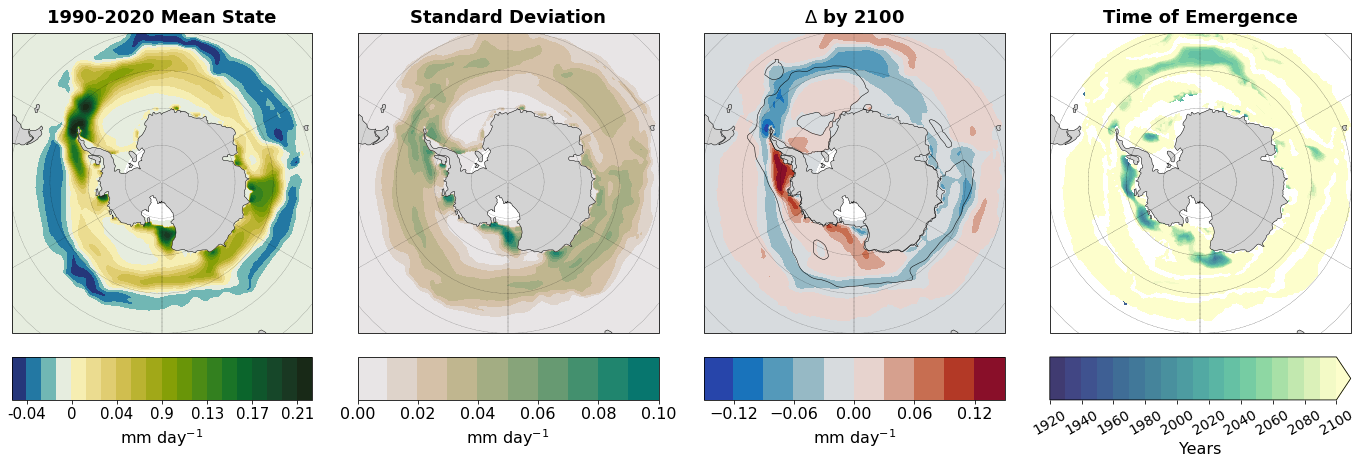

In [61]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,4, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3, t4 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'

dsp = dsp
plt_ttl = 'KGP: Mean-Std-Change-toe'

unit = 'mm day$^{-1}$'
unit2 = 'Years'
normal = MidpointNormalize(midpoint=0.)

level, cmapper, normed = levels, cmap, normal

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = epoch_plot(dsp.curr,level, cmapper, normed,lines = False)

#  COLORBAR FOR Current Mean PLOT
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=15,rotation = 0)

################### 2nd Left PLOT: Standard Deviation ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = std_plot(dsp.stdev,levels_std,cmap_std)

#  COLORBAR FOR Standard Deviation PLOT
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### 2nd RIGHT PLOT: Change by 2100 ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)

cf = change_plot(dsp.change, dsp.future, levels_chng, cmap_chng, MidpointNormalize(midpoint=0.))

#  COLORBAR FOR Change by 2100 PLOT
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels_diff)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### FAR RIGHT PLOT: TOE ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cf = toe_plot(dsp.ToE)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(levels_toe[::2])
cb.ax.tick_params(labelsize=14, rotation = 30)

#--------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

## For Each Variable, make polar plottable datasets:
SST

In [130]:
# Polar Plottable
dsp_sst = util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.SST,
        'curr':ds_curr_mean.SST,
        'stdev': ds_ctrl_std.SST,
        'change': ds_fut_mean.SST - ds_curr_mean.SST,
        'ToE': ds_toe.SST_toe,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
dsp_sst

<xarray.Dataset>
Dimensions:  (nlat: 93, nlon: 321)
Coordinates:
    length   float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    ctrl     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    curr     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stdev    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    change   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ToE      (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>

## Set Levels etc 

In [166]:
# Control
levels = np.arange(-2,6,.5)#np.linspace(-1.5, 10, 23)
# STDEV 
levels_std = np.linspace(0, 1.5, 11)
#labels_std = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]
# SST Change 
levels_chng = np.arange(-1,6,.5)
labels_diff = []
levels_cont = [-1, 5]

#Colors
cmap = cmocean.cm.thermal
cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

#Standard
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

In [167]:
def epoch_plot(da, level, cmapper, normed):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level, extend = 'both',
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [168]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [169]:
def change_plot(da, level, cmapper, normed):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=normed,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

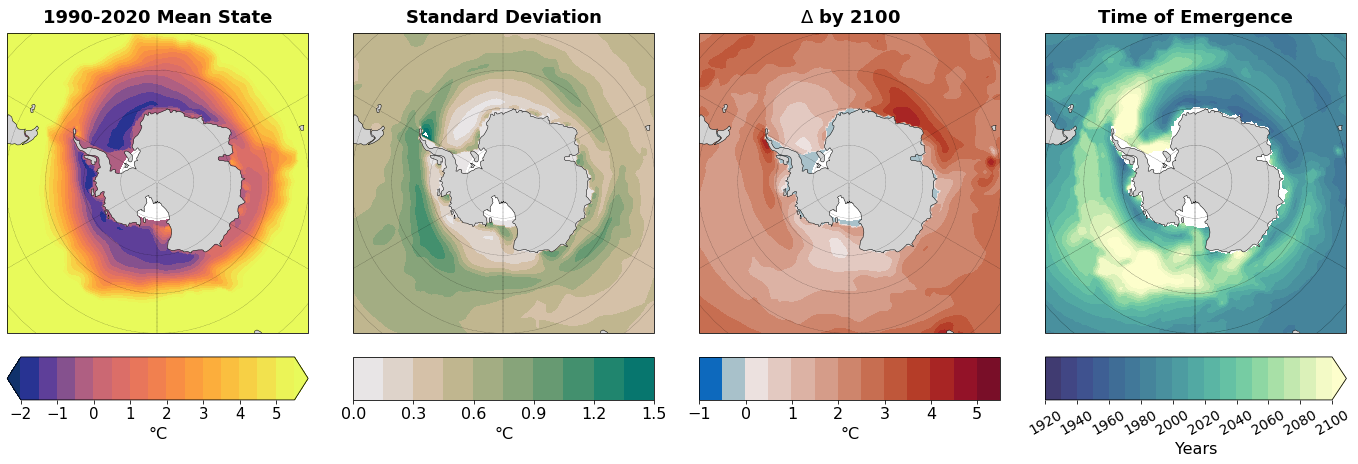

In [171]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,4, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3, t4 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'

dsp = dsp
plt_ttl = 'SST: Mean-Std-Change-toe'

unit = '°C'
unit2 = 'Years'
normal = MidpointNormalize(midpoint=0.)

level, cmapper, normed = levels, cmap, normal

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = epoch_plot(dsp_sst.curr,level, cmapper, normed)

#  COLORBAR FOR Current Mean PLOT
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=15,rotation = 0)

################### 2nd Left PLOT: Standard Deviation ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = std_plot(dsp_sst.stdev,levels_std,cmap_std)

#  COLORBAR FOR Standard Deviation PLOT
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### 2nd RIGHT PLOT: Change by 2100 ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)

cf = change_plot(dsp_sst.change, levels_chng, cmap_chng, MidpointNormalize(midpoint=0.))

#  COLORBAR FOR Change by 2100 PLOT
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels_diff)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### FAR RIGHT PLOT: TOE ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cf = toe_plot(dsp_sst.ToE)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(levels_toe[::2])
cb.ax.tick_params(labelsize=14, rotation = 30)

#--------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

___
# Repeat for Chl

In [133]:
# Polar Plottable
dsp_chl = util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.Chl_surf,
        'curr':ds_curr_mean.Chl_surf,
        'stdev': ds_ctrl_std.Chl_surf,
        'change': ds_fut_mean.Chl_surf - ds_curr_mean.Chl_surf,
        'ToE': ds_toe.Chl_surf_toe,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
dsp_chl

<xarray.Dataset>
Dimensions:  (nlat: 93, nlon: 321)
Coordinates:
    length   float64 40.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    ctrl     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    curr     (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stdev    (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    change   (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ToE      (nlat, nlon) float64 dask.array<chunksize=(93, 161), meta=np.ndarray>

### Set up levels

In [134]:
# STDEV 
levels_std = np.linspace(0,2,11)
norm_std = colors.LogNorm(vmin=levels_std.min(), vmax=levels_std.max())
#labels_std = [0.0, 0.015, 0.03,0.45,0.60,0.75,0.9]

# CHL Change 
level_p = [0, 0.219]
levels_cont = [0, 0.5]

#Colors
cmap = cmocean.cm.dense
#cmap = cmocean.tools.crop_by_percent(cmap, 10, which='min', N=None)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

### Run Plotting Functions

In [135]:
# Set log normalized levels for Chlorophyll
levels = np.logspace(-2,.8,11) #np.logspace(-1.65,.22,11)
# Double check your levels
print(['{:f}'.format(x) for x in levels])
# Model and Observation Colors
cmap = cmocean.tools.crop_by_percent(cmocean.cm.dense, 10, which='max', N=None)
#norm = colors.LogNorm(vmin=levels[0], vmax=levels[-1])
norm = colors.BoundaryNorm(levels, cmap.N)

def chl_plot(da, lines=True):
    # filled contours at set levels
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da, #np.log10(da),
                     levels=levels,
                     norm=norm,
                     cmap=cmap,
                     transform=ccrs.PlateCarree())

    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf


['0.010000', '0.019055', '0.036308', '0.069183', '0.131826', '0.251189', '0.478630', '0.912011', '1.737801', '3.311311', '6.309573']


In [162]:
levels_chng = np.linspace(-1.25,1.25,11)#np.arange(-1.8,1.8,.2) #[-3.4, -2.6, -1.8, -0.9, -0.08, 0.8, 1.6]

oldnorm = MidpointNormalize(midpoint=0.)
#divnorm = colors.TwoSlopeNorm(vmin=-1.5., vcenter=0, vmax=1.16)

cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)


def change_plot(da):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=oldnorm,
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

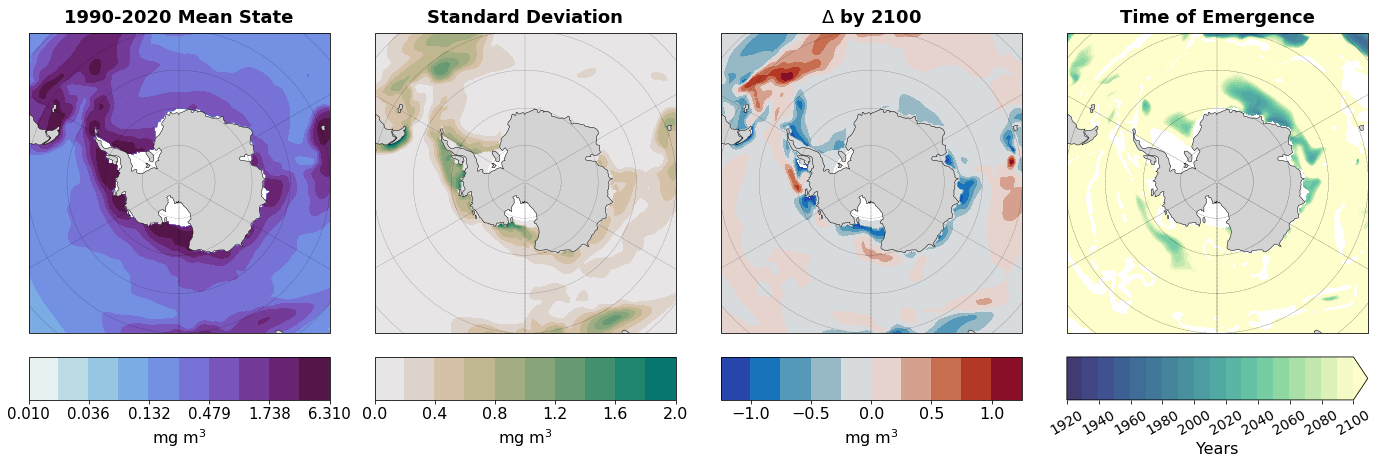

In [165]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,4, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3, t4 = '1990-2020 Mean State', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'

dsp = dsp
plt_ttl = 'CHL: Mean-Std-Change-toe'

unit = 'mg m$^3$'
unit2 = 'Years'
normal = MidpointNormalize(midpoint=0.)

level, cmapper, normed = levels, cmap, normal

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = chl_plot(dsp_chl.curr)#,level, cmapper, normed)

#  COLORBAR FOR Current Mean PLOT
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=15,rotation = 0)

################### 2nd Left PLOT: Standard Deviation ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = std_plot(dsp_chl.stdev,levels_std,cmap_std)

#  COLORBAR FOR Standard Deviation PLOT
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### 2nd RIGHT PLOT: Change by 2100 ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)

cf = change_plot(dsp_chl.change)

#  COLORBAR FOR Change by 2100 PLOT
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels_diff)
cb.ax.tick_params(labelsize=16,rotation = 0)

################### FAR RIGHT PLOT: TOE ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cf = toe_plot(dsp_chl.ToE)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(levels_toe[::2])
cb.ax.tick_params(labelsize=14, rotation = 30)

#--------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

___

## Change in Positive GP Area

In [80]:
# Polar Plottable
dsp_gp = util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.KGP,
        'curr':ds_curr_mean.KGP,
        'stdev': ds_ctrl_std.KGP,
        'future':ds_fut_mean.KGP,
        'change': ds_fut_mean.KGP - ds_curr_mean.KGP,
        'ToE': ds_toe.KGP_toe,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
#dsp_gp

### Set variable specific limits, levels, etc

In [103]:
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
cmap = cmocean.cm.delta
cmap_chng = cmocean.cm.balance
cmap_chng = cmocean.tools.crop_by_percent(cmap_chng, 15, which='both', N=None)

# Levels
levels = np.linspace(-0.05, 0.22, 21)
levels_chng = np.linspace(-0.15, 0.15, 11)
midpoint = MidpointNormalize(midpoint=0.)

# KGP 
pos_gp = [0, 0.213]


### Run plotting functions

In [104]:
def epoch_plots(da):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=level, #extend = 'both',
                     norm=midpoint,
                     cmap=cmapper,
                     transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [105]:
def change_plot(da, dc):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_chng,
                     norm=midpoint,
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, dc,
                    colors='k', 
                    levels=pos_gp,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

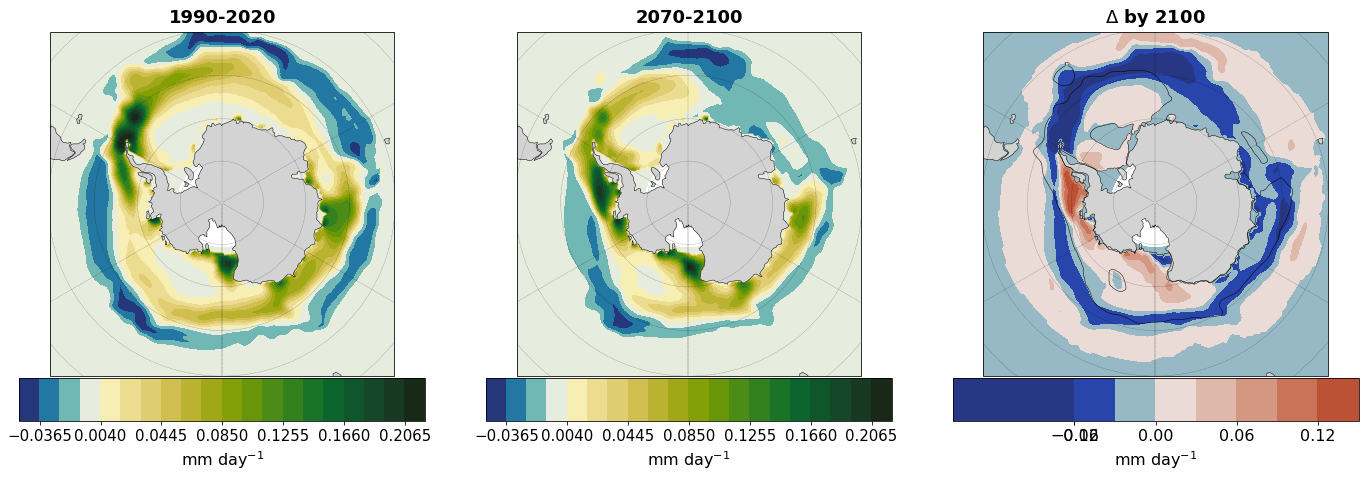

In [106]:
plt_ttl = 'kgp-changes'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,3, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2, t3 = '1990-2020', '2070-2100', '$\Delta$ by 2100'
unit = 'mm day$^{-1}}$'

dsp = dsp_gp
level, cmapper = levels, cmap

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = epoch_plots(dsp.curr)

#  COLORBAR FOR Current Mean PLOT
cbax = plt.subplot(gs[1,0]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
# cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=15,rotation = 0)

################### MIDDLE PLOT: Future Mean ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = epoch_plots(dsp.future)

#  COLORBAR FOR Current Mean PLOT
cbax = plt.subplot(gs[1,1]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
# cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=15,rotation = 0)

################### RIGHT PLOT: Change by 2100 ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)

cf = change_plot(dsp.change, dsp.future)

#  COLORBAR FOR Change by 2100 PLOT
cbax = plt.subplot(gs[1,2]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels_diff)
cb.ax.tick_params(labelsize=16,rotation = 0)
# #--------------------------------------------------------
# title = (f'{plt_ttl}')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

In [39]:
print(np.round(dsp.curr.max().values, 3), np.round(dsp.future.max().values, 3))

0.218 0.213


In [113]:
pos_gp_f = [0, 0.213]
pos_gp_p = [0, 0.218]

def bones(da, pos_level):
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    levels=pos_level,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
#     # land
#     land = ax.add_feature(
#         cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
#                                             facecolor='lightgray'))
#     ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

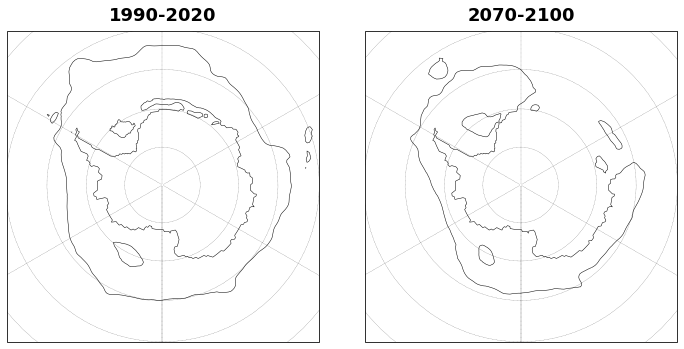

In [114]:
plt_ttl = 'kgp-barest-bones-changes'
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2,2, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
t1, t2 = '1990-2020', '2070-2100'
unit = 'mm day$^{-1}}$'
dsp = dsp_gp

################### LEFT MOST PLOT: Current Mean ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

cf = bones(dsp.curr, pos_gp_p)

################### MIDDLE PLOT: Future Mean ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

cf = bones(dsp.future, pos_gp_f)

#--------------------------------------------------------
title = (f'{plt_ttl}')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')
